In [1]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import scipy.stats as stats
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Roboto']
from matplotlib.colors import ListedColormap


col = ['#5052c7', '#1c84b3', '#0fb390', '#f09816', '#fb3856', '#41429f', '#166a8f', '#0b9072', '#c07a12', '#c92d45']

In [2]:
telco_df = pd.read_csv('Data Sets/telco-train-dataset.csv')
telco_df = telco_df.dropna()
telco_df.head()

,customerID,Male,SeniorCitizen,Partner,Dependents,tenure,Phone,MultipleLines,DSL,FiberOptic,...,StreamingMovies,OneYear,TwoYear,PaperlessBilling,CreditCard,BankTransfer,ElectronicCheck,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,1,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,0,1,0,0,0,0,0,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,0,...,0,0,0,1,0,0,0,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,0,1,0,0,0,1,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,0,1,...,0,0,0,1,0,0,1,70.70,151.65,1


In [3]:
def plot_LR(x):
    return 1/(1+np.exp(-x))

In [4]:
def plot_decision_region(X, y, classifier, resolution = 0.02, decRegion=True):    
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = col
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    x2_min, x2_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure(figsize = (10,10))
    
    if decRegion == True:
        plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap=cmap)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl].iloc[:,0], 
                   y=X[y==cl].iloc[:,1],
                   alpha = 0.8, 
                   c = colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')
        
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.legend()
    plt.show()
    
        
def plot_scatter_2d(df, x1, x2, y):
    """"
    Description: Plots a scatter plot of two dependent variables, with different color/shape per class
    IMPORTRANT: Works for only 2 independent variables, given 1 dependent
    
    Parameters:
        df(n x m): dataframe containing variables of interest
        x1 (string): name of x-axis variable
        x2 (string): name of y-axis variable
        y (string): name of labels
        
    Returns:
        Scatter plot
    """
    f, ax = plt.subplots(1)
    for idx, cl in enumerate(np.unique(df[y])):
        
        ax.scatter(x=df[df[y]==cl][x1], 
                   y=df[df[y]==cl][x2],
                   c = col[idx],
                   label=cl)
        
    plt.show()
    
def plot_me(df, y):
    """
    Description: Compares the population of all variables in a dataframe against a set label
    
    Parameters:
        df(n x m): dataframe containing variables of interest
        y (string): name of labels   
        
    Returns:
        Stacked 100% Bar charts of crosstabs of all variables againt the Y variable
    
    """
    labels = df[y]
    new_df = df.drop(y, axis = 1)
    
    plots = new_df.shape[1]
    columns = 3
    rows = math.ceil(plots/columns)
    
    f,ax = plt.subplots(rows, columns, figsize = (20,20))
    for i in range(plots):
        temp_row = new_df.iloc[:,i]
        if len(temp_row.unique()) > 5:
            temp_row = pd.cut(temp_row, 5)
        
        pd.crosstab(labels, temp_row, normalize='index').plot(kind='bar', stacked=True, ax= ax[int(i/rows), i%rows], color = col)
        ax[int(i/columns), i%rows].set_title(new_df.columns[i])
        
    plt.tight_layout()
    plt.show()


def get_rocCurve(Y_actual, Y_predict):
    """
    Description: Plots the ROC Curve given the actual vs predicted values
    
    Parameters:
        Y_actual: True labels
        Y_predict: prediction PROBABILITIES given an X feature set
        
    Returns:
        ROC Curve
    
    """
    from sklearn.metrics import roc_curve, auc
    # Compute ROC curve and ROC area for each class

    fpr, tpr, _ = roc_curve(Y_actual, Y_predict)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color=col[4],
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=col[1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def get_conf(Y_actual, Y_predict):
    """
    Description: Calculate the model accuracy metrics given actuals vs predicted
    
    Parameters:
        Y_actual: True labels
        Y_predict: prediction LABELS given an X feature set
        
    Returns:
        number of true positive, true negative, false positive, false negative
        Accuracy
        True Positive Rate/Recall
        True Negative Rate
        Precision
        F1 Score
    
    """
    trial = pd.DataFrame([Y_actual,Y_predict]).T
    trial['lol'] = abs(trial[0]-trial[1])


    tp = trial[(trial[0]==1)&(trial['lol']==0)].shape[0]
    tn = trial[(trial[0]==0)&(trial['lol']==0)].shape[0]
    fp = trial[(trial[0]==0)&(trial['lol']==1)].shape[0]
    fn = trial[(trial[0]==1)&(trial['lol']==1)].shape[0]
    
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    tpr = tp/(tp+fn)
    tnr = tn/(fp+tn)
    precision = tp/(fp+tp)
    f1 = (2*tpr*precision)/(precision+tpr)
    
    return({'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn, 'acc':accuracy, 'tpr':tpr, 'tnr':tnr, 'precision':precision, 'f1':f1})

In [87]:
telco_df.TotalCharges = pd.to_numeric(telco_df.TotalCharges, errors ='coerce')
telco_df = telco_df.dropna()
X_train, X_test, Y_train, Y_test = train_test_split(telco_df.drop(['customerID','Churn','Partner','CreditCard','BankTransfer','ElectronicCheck', 
'Male','Phone','OnineBackup','OnlineSecurity','TechSupport','DeviceProtection'], axis = 1).astype(float), telco_df['Churn'], test_size = 0.2)

In [88]:
logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.422671
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5227
Model:                          Logit   Df Residuals:                     5214
Method:                           MLE   Df Model:                           12
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:                  0.2722
Time:                        21:48:27   Log-Likelihood:                -2209.3
converged:                       True   LL-Null:                       -3035.4
                                        LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
SeniorCitizen        0.2971      0.096      3.087      0.002       0.109       0.486
Dependents          -0.1701      0.092     -1.847      0.065      -0.351       0.010
tenure              -0.0662      0.006    -10.578      0.000      -0.078      -0.054
MultipleLines        0.5096      0.095      5.341      0.000       0.323       0.697
DSL                  1.8173      0.193      9.398      0.000       1.438       2.196
FiberOptic           3.8759      0.307     12.622      0.000       3.274       4.478
StreamingTV          0.7433      0.100      7.404      0.000       0.547       0.940
StreamingMovies      0.6568      0.100      6.555      0.000       0.460       0.853
OneYear             -0.8000      0.123     -6.492      0.000      -1.042      -0.558
TwoYear             -1.5618      0.199     -7.844      0.000      -1.952      -1.172
PaperlessBilling     0.3110      0.083      3.730      0.000       0.148       0.474
MonthlyCharges      -0.0495      0.004    -11.813      0.000      -0.058      -0.041
TotalCharges         0.0004   6.98e-05      5.792      0.000       0.000       0.001
====================================================================================
"""

In [89]:
np.exp(result.params)

SeniorCitizen        1.345985
Dependents           0.843598
tenure               0.935955
MultipleLines        1.664651
DSL                  6.155225
FiberOptic          48.224391
StreamingTV          2.102800
StreamingMovies      1.928623
OneYear              0.449334
TwoYear              0.209755
PaperlessBilling     1.364820
MonthlyCharges       0.951745
TotalCharges         1.000404
dtype: float64

In [105]:
thresh = 0.549
print(accuracy_score(result.predict(X_train).apply(lambda x: x>thresh), Y_train))
print(accuracy_score(result.predict(X_test).apply(lambda x: x>thresh), Y_test))

0.8004591543906638
0.8201989288446825


Text(0,0.5,'Accuracy')

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

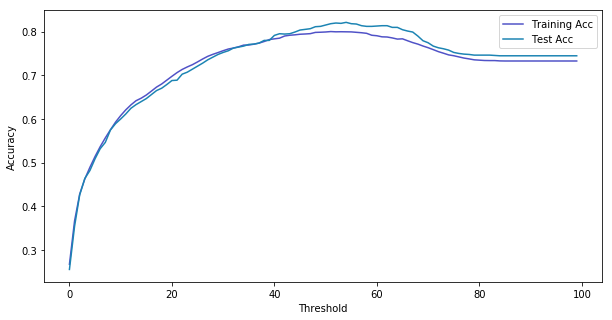

In [91]:
thresh_list = np.linspace(0, 1, 100)
train_acc = []
test_acc = []

for t in thresh_list:
    train_acc.append(accuracy_score(result.predict(X_train).apply(lambda x: x>t), Y_train))
    test_acc.append(accuracy_score(result.predict(X_test).apply(lambda x: x>t), Y_test))    
    
pd.DataFrame({'Training Acc':train_acc, 'Test Acc':test_acc}).plot(color = col, figsize = (10,5))
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

In [106]:
get_conf(Y_train.values, result.predict(X_train).apply(lambda x: x>0.5).values)

{'tp': 765,
 'tn': 3412,
 'fp': 417,
 'fn': 633,
 'acc': 0.7991199540845609,
 'tpr': 0.5472103004291845,
 'tnr': 0.8910942804909898,
 'precision': 0.6472081218274112,
 'f1': 0.5930232558139534}

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

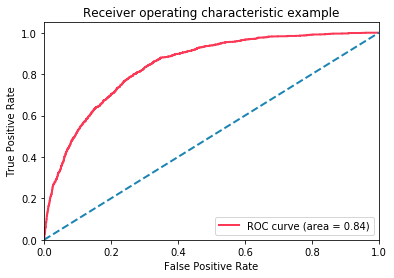

In [107]:
get_rocCurve(Y_train, result.predict(X_train))

In [58]:
result.predict(X_train)

5248    0.050610
4426    0.352985
6194    0.075105
6223    0.607972
383     0.715680
1230    0.298999
1219    0.111848
3113    0.609715
2451    0.259085
825     0.479213
1569    0.190804
1745    0.003111
6417    0.277042
3070    0.407174
3194    0.171108
1476    0.242774
654     0.186774
5163    0.307949
4991    0.148030
3216    0.282896
2354    0.037802
5784    0.395105
5823    0.121602
2122    0.282209
2973    0.256645
6449    0.261120
3831    0.377515
5107    0.103947
41      0.010439
3430    0.069541
          ...   
3911    0.173908
174     0.023670
5221    0.178538
1090    0.206011
3928    0.599976
6293    0.018199
5313    0.287866
3678    0.231769
4546    0.503293
4435    0.548722
6068    0.297783
412     0.496748
2018    0.458479
623     0.022543
3049    0.236357
74      0.333623
3346    0.774685
1814    0.031527
599     0.002127
1948    0.624325
3999    0.678075
1337    0.011153
641     0.086493
5387    0.509539
1921    0.013864
3298    0.223221
5879    0.019866
4725    0.3027